# Bayesian PCA
Includes bias and noise.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, StudentT

from plot_utils import * # see plot_utils.py

import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector

In [4]:
ledermann_bound = lambda p: (2*p+1-(8*p+1)**.5)*.5

In [5]:
# note that in the function below D should be greater then K
def build_toy_dataset(N, D, K):
    x_train = np.zeros([D, N])
    w = np.zeros([D,K])
    for k in range(K):
        w[k,k]=1.0/(k+1)
        w[k+1,k]=-1.0/(k+1)
    print(w)
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    shift=np.zeros([D])
    shift[0]=10
    shift[1]=23
    sigma = np.ones(D)+0.1
    for d in range(D):
      for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma[d])+shift[d]
#     print("True principal axes:")
#     print(w)
#     print("Shift:")
#     print(shift)
    return x_train.astype(np.float32,copy=False), w, shift, sigma


#ed.set_seed(142)

N = 1000  # number of data points
D = 8  # data dimensionality
K = 3 # latent dimensionality

# DATA

x_train, w_true, shift, sigma_true = build_toy_dataset(N, D, K)

[[ 1.          0.          0.        ]
 [-1.          0.5         0.        ]
 [ 0.         -0.5         0.33333333]
 [ 0.          0.         -0.33333333]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [6]:
ledermann_bound(D) # if this is > K, model should be identifiable according to Identifiability of Factor Analysis: Some Results and Open Problems

4.468871125850725

In [7]:
shift

array([ 10.,  23.,   0.,   0.,   0.,   0.,   0.,   0.])

In [8]:
sigma_true

array([ 1.1,  1.1,  1.1,  1.1,  1.1,  1.1,  1.1,  1.1])

In [9]:
x_train = x_train.T # n x d please, not d x n

In [10]:
from tensorflow.python.client import device_lib

In [11]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16907794127923286389]

In [12]:
def pairplot(x):
    scattermatrix2 = sns.pairplot(pd.DataFrame(x))
    #[ax.set_ylim(-40,40) for ax in scattermatrix2.axes.flatten()]
    #[ax.set_xlim(-40,40) for ax in scattermatrix2.axes.flatten()];
    plt.show()

def doublepairplot(x,y):
    N = x.shape[0]
    xy = pd.DataFrame(np.c_[np.r_[x,y],np.r_[np.zeros(N),np.ones(N)]])
    names = 'abcdefghijk'[:D+1]
    xy.columns = [i for i in names]
    sns.set()
    scattermatrix = sns.pairplot(xy, hue=names[-1], diag_kind= 'kde', vars = [i for i in names[:-1]])#, plot_kws=dict(alpha=.2))

## P-model

\begin{align}
i \in {1,...,D}\\
j \in {1,...,K}\\
n \in {1,...,N}\\
\tau &\sim StudentT(1,0)\\
\lambda_j &\sim StudentT(1,0)\\
w_{ij}&\sim N(0,|\tau||\lambda_j|)\\
z_{jn}&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma_i &\sim Gamma(1,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,\sigma_i)\\
\end{align}

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [13]:
class low_rank_mvn_horseshoe_ard():
    def __init__(self,M,D):
        # Fit as many latent variables as dimensions, prune by ARD
        K=D
        #########
        # halfCauchy = StudentT(df=1., loc=0., scale=1.)
        # Horseshoe! Happy now, Aki? Hyva!
        #########
        # P-model
        sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
        tau = StudentT(df=1., loc=0., scale=1.)
        lamda = StudentT(df=1., loc=tf.zeros([K]), scale=tf.ones([K]))
        w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
        z = Normal(tf.zeros([M, K]),    tf.ones([M, K]))
        mu = Normal(tf.zeros([D]),       tf.ones([D]))
        x = ed.models.MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z, transpose_b=True)),mu), tf.reshape(tf.tile(sigma,[M]),[M,D]))

        self.Pmodel = (sigma,lamda,tau,w,z,mu)
        self.x = x
        #########
        # Q-model
        qtau = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([])),
                                                       tf.Variable(tf.random_normal([]))),
        bijector=bijector.Exp(),
        name="qtau")
        
        qlamda = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([K])),
                                                       tf.Variable(tf.zeros([K]))),
        bijector=bijector.Exp(),
        name="qlamda")
        qw = Normal(tf.Variable(tf.random_normal([D, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
        qz = Normal(tf.Variable(tf.random_normal([M, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([M, K]))))

        # assume standardized data
        qmu = Normal(tf.Variable(tf.random_normal([D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        qsigma = ed.models.TransformedDistribution(
            distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
                                          tf.Variable(tf.ones(D))),
            bijector=bijector.Exp(),
            name="qsigma")

        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)
        
    def initialize(self, x_train):
        '''
        Initialize parameters of Q-model in the solution from PCA, and empirical means and standard deviations, for faster convergence.
        '''
        K=D
        N = x_train.shape[0]
        x_train = x_train.astype(np.float32)
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # set qmu mean to data mean
        data_mean = np.mean(x_train,axis=0).astype(np.float32,copy=False)
        qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        # set qsigma mean to data stds
        data_std = np.std(x_train,axis=0).astype(np.float32,copy=False)
        qsigma = ed.models.TransformedDistribution(
            distribution=ed.models.NormalWithSoftplusScale(tf.Variable(np.log(data_std)),
                                          tf.Variable(tf.ones(D)*3)),
            bijector=bijector.Exp(),
            name="qsigma")
        # set qw mean to ppca solution (see 12.61 in Murphy)
        try:
            # x_train might be too big for svd
            _,S,V = np.linalg.svd(x_train-x_train.mean(0), full_matrices=False)
        except MemoryError:
            # in that case, sample 1% of it, or 1000 observations, whichever is bigger
            x_train_subsample = x_train[np.random.choice(N,max(1000,np.floor(0.01*N))),:]
            _,S,V = np.linalg.svd(x_train_subsample-x_train_subsample.mean(0), full_matrices=False)
        qw = Normal(tf.Variable(np.dot(V,np.diag(S))/np.sqrt(N-1)),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
#        qw = Normal(tf.Variable(np.dot(V.T,np.diag(S))/np.sqrt(N-1)),
#                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)
            # add mini-batches
        # add mini-batches
    def generator(self, arrays, batch_size):
        # assuming arrays is a list of arrays of equal length, with rows being observations
        while True:
            batches = []
            random_idx = np.random.choice(arrays[0].shape[0], batch_size)
            for array in arrays:
                batches.append(array[random_idx])
            yield batches

    def infer(self, x_train, n_epoch = 100, n_print=100, n_samples=100, M = 100, optimizer='rmsprop'):
        self.data = self.generator([x_train], M)
        self.x_ph = tf.placeholder(tf.float32, [None,D])
        n_batch = int(N / M)
        # add progress bar
        self.inference = ed.KLqp(dict(zip(self.Pmodel,self.Qmodel)), data={self.x: self.x_ph})
        self.inference.initialize(n_iter=n_batch * n_epoch, n_print=(n_batch * n_epoch)/10, n_samples=n_samples, optimizer=optimizer)
        sess = ed.get_session()
        init = tf.global_variables_initializer()
        init.run()
        self.iterate(self.inference)
        
    #def infer_more(self, n_epoch = 100, n_print=100, n_samples=100, M = 100, optimizer='rmsprop'):
    
    # This won't work unless I initialize all uninitialized variables. I must either find all the variables that are created
    #, or just go through all variables, check if they are uninitialized, and initialize them. But I don't like that :<
    
    #    n_batch = int(N / M)
    #    self.more_inference = ed.KLqp(dict(zip(self.Pmodel,self.Qmodel)), data={self.x: self.x_ph})
    #    self.more_inference.initialize(n_iter=n_batch * n_epoch, n_print=(n_batch * n_epoch)/10, n_samples=n_samples, optimizer='rmsprop')
    #    self.iterate(self.more_inference)
    
    def iterate(self, inference = None, n_iter = None):
        if inference is None:
            inference = self.inference
        if n_iter is None:
            n_iter = self.inference.n_iter
        # assert x_ph.shape[0] == M 
        learning_curve = []
        for _ in range(n_iter):
            x_batch = next(self.data)[0]
            info_dict = inference.update({self.x_ph: x_batch})
            if _%inference.n_print == 0:
                print(info_dict)
            learning_curve.append(info_dict['loss'])
        plt.semilogy(learning_curve)
        plt.show()
    
    def prior_predictive_check(self):
        self.x_prior = ed.copy(self.x)
        pass
        
    def posterior_predictive_check(self, x_test):
        self.x_post = ed.copy(self.x, dict(zip(self.Pmodel,self.Qmodel)))
        self.pred_ll = ed.evaluate('log_likelihood', data={self.x_post: x_test})
    
    def plot_histograms(self,n_hist=3000):
        for variable in meddle.Qmodel:
            plt.show()
            if all([i < 10 for i in variable.shape]):
                samples = variable.sample(n_hist).eval()
            else:
                samples = variable.sample().eval()
            if variable.shape == []:
                plt.hist(samples,'auto')
                plt.title(variable.name)
            else:
                for dimension in range(variable.shape[0]):
                    plt.hist(samples[:,dimension],'auto')
                    plt.title(variable.name)
                    
    def print_model(self):
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # add pair plots
        print("Inferred principal axes (columns):")
        print(qw.mean().eval())
        print(qw.variance().eval())
        print("Inferred center:")
        print(qmu.mean().eval())
        print(qmu.variance().eval())
        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)

In [14]:
M = 100
meddle = low_rank_mvn_horseshoe_ard(M,D)
meddle.initialize(x_train)

In [15]:
#meddle.prior_predictive_check()

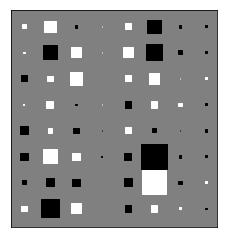

In [16]:
sess = ed.get_session()
tmp = sess.run([v.value() for v in [meddle.x, meddle.Pmodel[3]]])
sampled_from_prior,W_prior = tmp
np.round(W_prior,1)
hinton(W_prior.T)

In [17]:
x_train = sampled_from_prior

In [18]:
#pairplot(x_train)

sess = ed.get_session()
model = meddle.x.get_ancestors()
model.append(meddle.x)
model_sample = dict(zip(model,sess.run([[v.value() for i in range(10)] for v in model])))

meddle.prior_predictive_check()

# sample all variables ancestrally
model = meddle.x_prior.get_ancestors()
model.append(meddle.x_prior)
model_sample = dict(zip(model,sess.run([v.value() for v in model])))

sess = ed.get_session()
tmp = meddle.x_prior.sample().eval().T
with sess.as_default():
    plt.scatter(*tmp)
    plt.scatter(*x_train[:,:M])
    plt.axis('equal')
    plt.show()

In [19]:
N

1000

In [20]:
M

100

{'loss': 2.0473731e+09, 't': 1}
{'loss': 1.7816947e+08, 't': 301}
{'loss': 255252.34, 't': 601}
{'loss': 3847.3921, 't': 901}
{'loss': 2626.8096, 't': 1201}
{'loss': 2479.5098, 't': 1501}
{'loss': 2390.6196, 't': 1801}
{'loss': 2308.499, 't': 2101}
{'loss': 2266.8423, 't': 2401}
{'loss': 2219.48, 't': 2701}


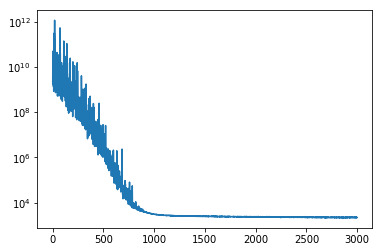

In [21]:
#meddle.infer(x_train, M=M, n_epoch = 300, n_samples = 300, optimizer='adadelta')
#meddle.infer(x_train, M=M, n_epoch = 300, n_samples = 300, optimizer= 'gradientdescent')
#meddle.infer(x_train, M=M, n_epoch = 300, n_samples = 300, optimizer= tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9, use_nesterov=True))
meddle.infer(x_train, M=M, n_epoch = 300, n_samples = 300)

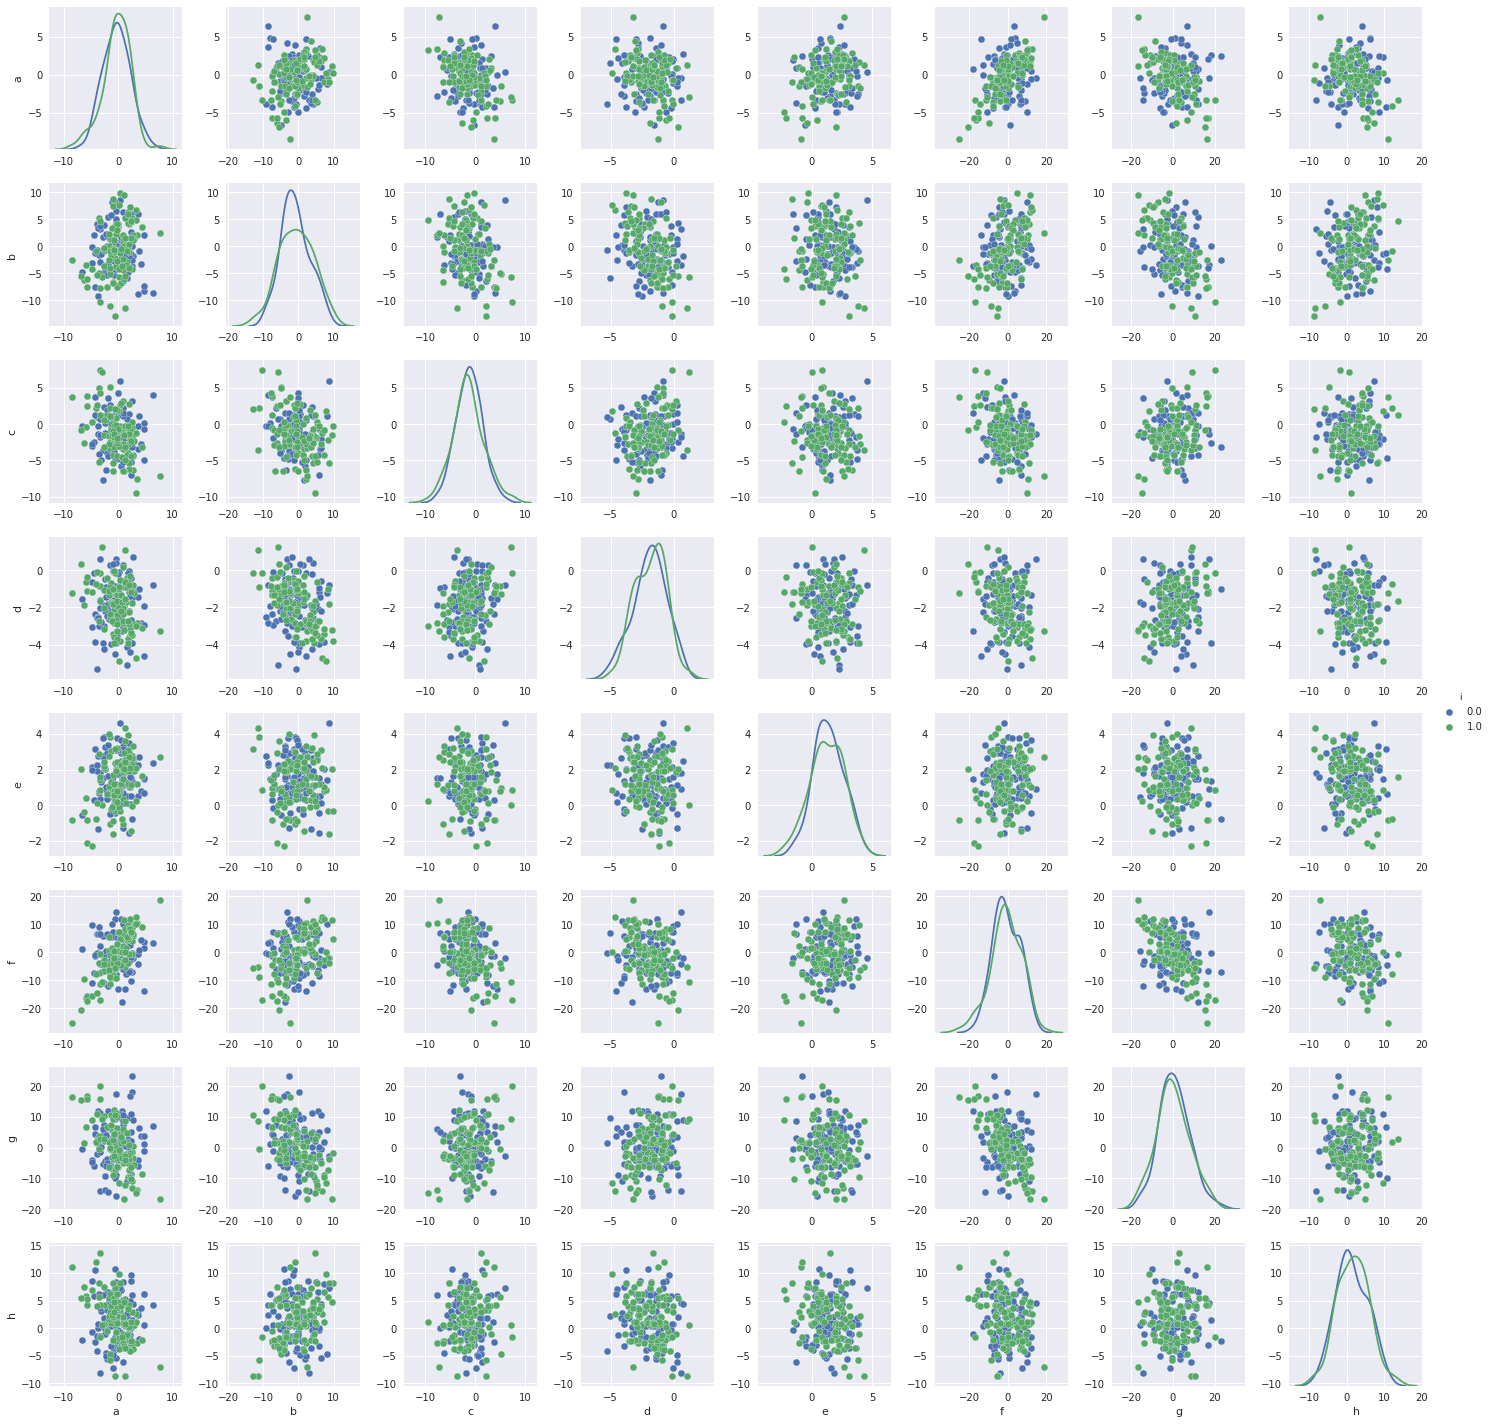

In [22]:
meddle.posterior_predictive_check(x_train[:M,:])
foo = meddle.x_post.sample().eval()
doublepairplot(foo,x_train[:M,:])

In [23]:
meddle.iterate()

{'loss': 2240.4417, 't': 3001}
{'loss': 2166.7378, 't': 3301}
{'loss': 2174.6152, 't': 3601}
{'loss': 2175.7083, 't': 3901}
{'loss': 2224.1611, 't': 4201}


KeyboardInterrupt: 

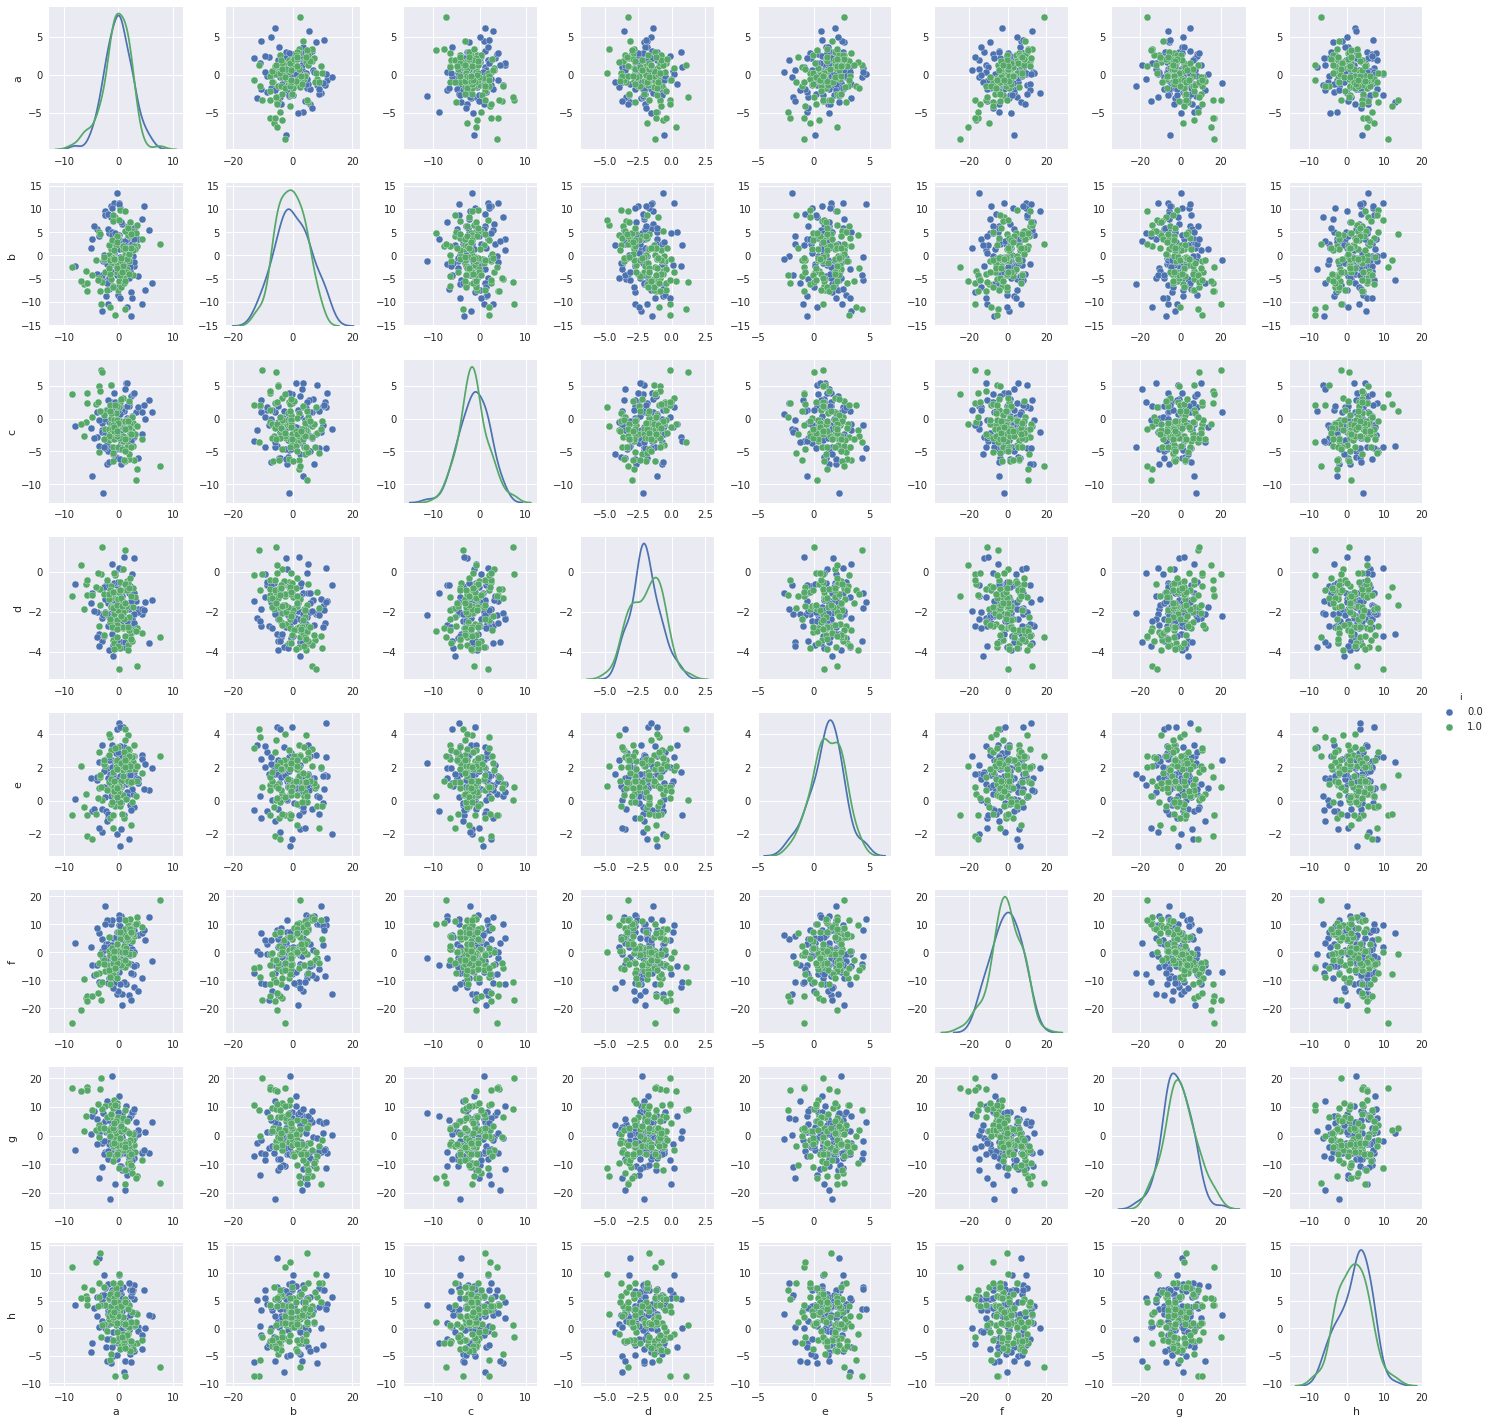

In [24]:
meddle.posterior_predictive_check(x_train[:M,:])
foo = meddle.x_post.sample().eval()
doublepairplot(foo,x_train[:M,:])

In [25]:
meddle.Qmodel

(<ed.RandomVariable 'qsigma_1/' shape=(8,) dtype=float32>,
 <ed.RandomVariable 'qlamda/' shape=(8,) dtype=float32>,
 <ed.RandomVariable 'qtau/' shape=() dtype=float32>,
 <ed.RandomVariable 'Normal_8/' shape=(8, 8) dtype=float32>,
 <ed.RandomVariable 'Normal_5/' shape=(100, 8) dtype=float32>,
 <ed.RandomVariable 'Normal_7/' shape=(8,) dtype=float32>)

In [26]:
qwmode = meddle.Qmodel[3].mode().eval()

In [27]:
np.round(qwmode,2)

array([[-0.  ,  0.  ,  0.  ,  0.01, -0.01,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.01, -0.01, -0.01, -0.  ,  0.  , -0.  ,  0.  ],
       [-0.  , -0.  ,  0.  , -0.  , -0.  , -0.01,  0.01,  0.  ],
       [ 0.  , -0.  , -0.01,  0.01, -0.  , -0.  ,  0.01, -0.  ],
       [ 0.  , -0.  ,  0.  , -0.  , -0.  , -0.01,  0.02, -0.01],
       [-0.  , -0.01, -0.  ,  0.01,  0.  , -0.  ,  0.  , -0.01],
       [-0.  ,  0.  ,  0.  ,  0.01, -0.  ,  0.01, -0.01,  0.  ],
       [-0.  ,  0.01, -0.01, -0.  ,  0.  , -0.01, -0.01,  0.01]], dtype=float32)

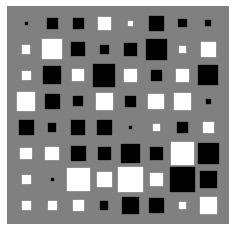

In [28]:
hinton(qwmode)

In [ ]:
hinton(np.pad(w_true,((0,0),(0,D-K)), 'constant', constant_values=0.001))

In [ ]:
meddle.plot_histograms()

## W_hat

In [ ]:
w_hat = meddle.Qmodel[3].mean().eval()
hinton(w_hat.T)
plt.show()

np.round(w_hat,1)

w_true

hinton(w_true.T)
plt.show()

## PCA solution:

In [ ]:
U,S,V = np.linalg.svd(x_train-x_train.mean(0))
#np.dot(V,np.diag(S))/np.sqrt(N-1)
whitened = np.sqrt(N-1)*U

In [ ]:
W_hat = np.dot(V,np.diag(S))/np.sqrt(N-1)

In [ ]:
white = np.random.normal(size=x_train.shape)

In [ ]:
tmp = np.dot(white,W_hat).T+x_train.mean(0)[:,np.newaxis]

In [ ]:
tmp.shape

In [ ]:
doublepairplot(x_train,tmp.T)

In [ ]:
pairplot(white)

In [ ]:
qsigma.get_variables()[0].eval()

sorted(np.exp(qsigma.get_variables()[0].eval()))

tmp = qw.mean().eval()

tmp[abs(tmp)>0.05]

sigma

In [ ]:
alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

In [ ]:
plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

In [ ]:
qsigma.get_variables()[0].eval()

In [ ]:
x_train.shape

In [ ]:
x_sim_sample = x_sim.sample().eval()

In [ ]:
x_sim_sample

In [ ]:
x_sim_sample.shape

In [ ]:
D

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
tpm = qtmp.sample(10000).eval()

plt.hist(tpm[:,0],'auto',normed=True)
plt.axis([0,50,0,1])
plt.show()
plt.hist(np.log(tpm[:,0]),'auto',normed=True)
plt.show()

In [ ]:
x_train.shape